## Import stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Set up the prior

In [2]:
lower = np.array([0])
upper = np.array([1])
prior = priors.Uniform(lower, upper)

## Load in the compressed data vector, sims, Fisher matrix, fiducial params
`compressed_data` is an array of length `n_summaries`<br>
`sim_params` is an array with shape `(n_simulations, n_parameters)`<br>
`sim_compressed_data` is an array with shape `(n_simulations, n_summaries)`

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 9000 # total number of datapoints
n_class = 9000 # number of different cosmologies for the training
q_prior = np.random.uniform(0, 1, n)
q_fid = np.random.uniform(0, 1, 1)
preprocess = True  # whether to preprocess the data or not

In [4]:
q_fid 

array([0.92989227])

In [5]:
n_vec = 50 # number of components of the data
# we create the observed data point, for now at the fiducial value of q
d_vec_obs = []
for _ in range(1):
    d_vec_obs.append([np.random.lognormal(q_fid, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

# we also create the data corresponding to a fixed noise, but different q
# together with that, we also create the FN data vectors for the posterior
d_vec_q = []
for q in q_prior:
    d_vec_q.append([np.random.lognormal(q, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

d_vec_obs = np.reshape(np.asarray(d_vec_obs), [-1, n_vec])
d_vec_obs_keep = np.copy(d_vec_obs)
d_vec_q = np.reshape(np.asarray(d_vec_q), [-1, n_vec])

print(d_vec_obs.shape, d_vec_q.shape)

if preprocess:
    pre_fac = 1.0
    def preprocess_data(d, M, m, pre_fac=1.0):
        return pre_fac*(d-m)/(M-m)
    minimum, maximum = d_vec_q.min(), d_vec_q.max()
    d_vec_obs = preprocess_data(d_vec_obs, minimum, maximum, pre_fac = pre_fac)
    d_vec_q = preprocess_data(d_vec_q, minimum, maximum, pre_fac = pre_fac)

(1, 50) (9000, 50)


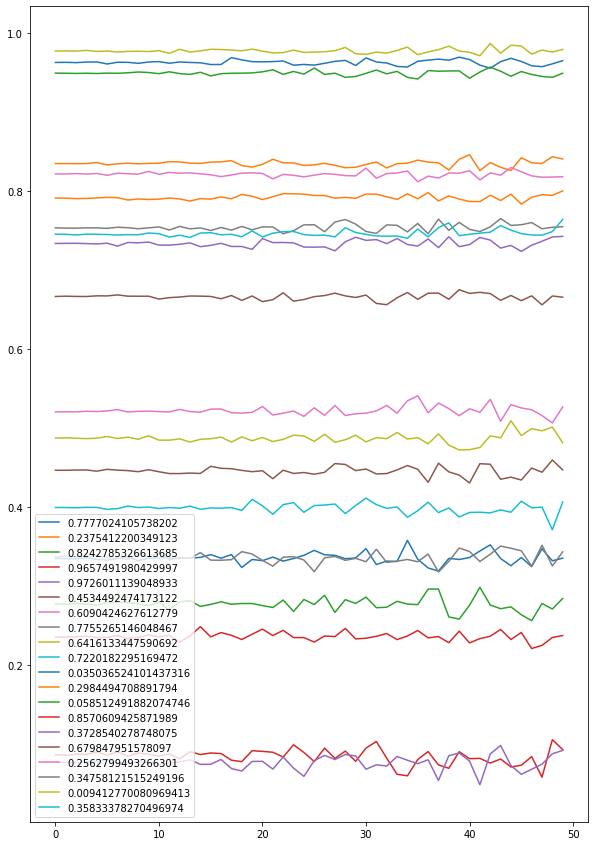

In [6]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(20):
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])

plt.legend()


## Autoencoder (AE)

In this case, since we are using an auto-encoder, we devise it such that:
- we minimise the L2 loss between the noisy realisation, with an additional bit on the variance;
- we minimise the L2 loss between the fixed-noise (fn) realisations;
- we optimise different part of the encoder-decoder with different losses;
- we do not care about the latent space distribution at this stage.

Problems of this compression include the fact that the L2 loss is too general.
As a pro, we do retain the capability of checkin the reconstruction in this case.

In [7]:
# we define the encoder and the decoder here
# there are some hyperparameters at the beginning; also, the dropout layers may be added upon need

activation_enc = 'relu'
activation_dec = 'relu'
batch_s = 128

def encoder(data, bs=batch_s, rate=0.0, is_reuse=False):
    with tf.variable_scope('noise_encoder') as scope:
        if is_reuse is True:
            scope.reuse_variables()
        x = tf.reshape(data, shape=[-1, n_vec])
        dense1 = tf.layers.dense(x, 512, activation=getattr(tf.nn, activation_enc))
        dense2 = tf.layers.dense(dense1, 128, activation=getattr(tf.nn, activation_enc))
        dense3 = tf.layers.dense(dense2, 16, activation=getattr(tf.nn, activation_enc)) 
        dense4 = tf.layers.dense(dense3, 1)
        out = tf.reshape(dense4, [-1, 1])
    return out

def decoder(data, bs=batch_s, rate=0.0, is_reuse=False):
    with tf.variable_scope('noise_decoder') as scope:
        if is_reuse is True:
            scope.reuse_variables()
        x = tf.reshape(data, shape=[-1, 1])
        dense1 = tf.layers.dense(x, 16, activation=getattr(tf.nn, activation_dec))
        dense2 = tf.layers.dense(dense1, 128, activation=getattr(tf.nn, activation_dec))
        dense3 = tf.layers.dense(dense2, 512, activation=getattr(tf.nn, activation_dec))
        dense4 = tf.layers.dense(dense3, n_vec)
        out = tf.reshape(dense4, [-1, n_vec])
    return out

def next_batch(data1, num1, shuffle=True):
    """
    Return a total of 'num-i' random samples
    """
    if not shuffle:
        return np.asarray(data1)
    idx = np.arange(len(data1))
    np.random.shuffle(idx)
    idx = idx[:num1]
    data1_shuffle = [data1[i] for i in idx]
    return np.asarray(data1_shuffle)


In [8]:
# we set up the network and train
# divide data in train and validation - test will come after
noise_cls_train = d_vec_q[:3000, :]
noise_cls_valid = d_vec_q[3000:4000, :]
noise_cls_test = d_vec_q[4000:, :]

# just check that the split was successful
print('Train data shape: ', noise_cls_train.shape)
print('Valid data shape: ', noise_cls_valid.shape)

# to void problems with the notebook
tf.reset_default_graph()

# creating the network
noise_data = tf.placeholder(tf.float32, [None, n_vec], name='noise_cls')
drop_rate = tf.placeholder(tf.float32)  # needed in case of dropout
lr = tf.placeholder(tf.float32)

# define the model
# noise data encoder
z = encoder(noise_data, rate=drop_rate)
# noise data decoder
noise_data_tilde = decoder(z, rate=drop_rate)

Train data shape:  (3000, 50)
Valid data shape:  (1000, 50)


In [9]:
# defines the losses, and the parameters to optimise on
with tf.name_scope('z_auto_enc_loss'):
    #var_hat = tf.math.reduce_std(noise_data_tilde, axis=[0])
    #var = tf.math.reduce_std(noise_data, axis=[0])
    var_reg = tf.constant(0.0) 
    autoenc_loss = 1.0 * tf.reduce_mean(tf.reduce_sum(tf.square(noise_data - noise_data_tilde), axis=[1])) + 1.0*var_reg
    tf.summary.scalar('var_reg', var_reg)
    tf.summary.scalar('auto_enc_loss', autoenc_loss)

# variables to optimise on
autoenc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='noise_encoder') + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='noise_decoder')

# optimisation
with tf.name_scope('train'):
    optimize_autoenc = tf.train.AdamOptimizer(learning_rate = lr, beta1=0.5, beta2=0.9).minimize(autoenc_loss, var_list=autoenc_vars)

In [10]:
# now we train the AE
# getting ready to train
merged = tf.summary.merge_all()
saver = tf.train.Saver(max_to_keep=None)
init = tf.initialize_all_variables()
learning_rate = 1e-4
n_iter = 1000

print("Defined the data and the model, starting training")
print('Starting session')
#with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
sess = tf.Session()
sess.run(init)
train_writer = tf.summary.FileWriter('./train', sess.graph, filename_suffix='train')
test_writer = tf.summary.FileWriter('./test', sess.graph, filename_suffix='test')
for iteration in range(n_iter):
    # save the learning curves
    feed_train_noise_cls = next_batch(noise_cls_train, batch_s)
    feed = {noise_data: feed_train_noise_cls.reshape([-1, n_vec]),
       drop_rate: 0.0, lr: learning_rate}
    summary, train_autoenc_loss = sess.run([merged, autoenc_loss], feed_dict=feed)
    train_writer.add_summary(summary, iteration)
    feed_valid_noise_cls = next_batch(noise_cls_valid, batch_s)
    feed = {noise_data: feed_valid_noise_cls.reshape([-1, n_vec]),
      drop_rate: 0.0, lr: learning_rate}
    summary, test_autoenc_loss, test_var_reg = sess.run([merged, autoenc_loss, var_reg], feed_dict=feed)
    test_writer.add_summary(summary, iteration)
    if iteration % 100 == 0:
        print('Iteration', iteration+1, '/', n_iter, 'autoenc loss', test_autoenc_loss, 'var reg', test_var_reg)
    # we first train the autoencoder based on the noise
    feed_train_noise_cls = next_batch(noise_cls_train, batch_s)
    feed = {noise_data: feed_train_noise_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
    sess.run(optimize_autoenc, feed)

Defined the data and the model, starting training
Starting session
Iteration 1 / 1000 autoenc loss 20.37999 var reg 0.0
Iteration 101 / 1000 autoenc loss 0.02010523 var reg 0.0
Iteration 201 / 1000 autoenc loss 0.012282625 var reg 0.0
Iteration 301 / 1000 autoenc loss 0.0017868365 var reg 0.0
Iteration 401 / 1000 autoenc loss 0.007971068 var reg 0.0
Iteration 501 / 1000 autoenc loss 0.001976014 var reg 0.0
Iteration 601 / 1000 autoenc loss 0.0047489265 var reg 0.0
Iteration 701 / 1000 autoenc loss 0.0036857778 var reg 0.0
Iteration 801 / 1000 autoenc loss 0.009640544 var reg 0.0
Iteration 901 / 1000 autoenc loss 0.0016527725 var reg 0.0


In [11]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
feed_test_noise_cls = next_batch(noise_cls_test, 1000, shuffle=False)
feed = {noise_data: feed_test_noise_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
summaries_noise = sess.run(z, feed)
feed = {noise_data: d_vec_obs.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
summary_obs = sess.run(z, feed)

In [12]:
summaries_noise.shape

(5000, 1)

In [13]:
summary_obs.shape

(1, 1)

In [14]:
compressed_data = summary_obs[0]

sim_params = np.reshape(q_prior[4000:], [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs

In [15]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=1, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]
       

## Create DELFI object

In [16]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['q'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [17]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

## Fisher pre-training to initialize networks

In [18]:
#DelfiEnsemble.fisher_pretraining(n_batch=5000, batch_size=100)

# Train the networks

In [ ]:
DelfiEnsemble.train_ndes()

# Sample the learned posterior

In [20]:
#posterior_samples = DelfiEnsemble.emcee_sample()

# Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [21]:
#DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [23]:
# this shoudl give us the likelihood
n_bins = 5000
likelihood_arr = np.zeros((n_bins, 2))
for index, q_value in enumerate(sim_params):
    likelihood_arr[index, :] = q_value, DelfiEnsemble.log_likelihood_stacked(q_value, compressed_data)

In [24]:
likelihood_arr = likelihood_arr[likelihood_arr[:,0].argsort()]
likelihood_arr[:, 1] = np.exp(likelihood_arr[:, 1])
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [26]:
# now we need to plot all of this
# we first calculate the real posterior, and the one obtained from the data


def lognorm(data, mean, sigma):
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

real_posterior = 1
q_real = np.reshape(sim_params, [-1])

for i, d in enumerate(d_vec_obs_keep[0]):
    real_posterior *= real_post((i+1)/(n_vec*100.0), q_real, d)

real_posterior = real_posterior / real_posterior.sum()

indexs_to_order_by = q_real.argsort()
q_real = q_real[indexs_to_order_by]
real_posterior = real_posterior[indexs_to_order_by]

posterior = []
q_posterior = np.reshape(sim_params, [-1])
for value in q_posterior:
    likelihood = 1
    for i, d in enumerate(d_vec_obs_keep[0]):
        likelihood *= lognorm(d, value, (i+1)/(n_vec*100.0))
    posterior.append(likelihood)

posterior = np.reshape(np.asarray(posterior), [n_bins])
# order points by their x-value
indexs_to_order_by = q_posterior.argsort()
q_posterior = q_posterior[indexs_to_order_by]
posterior = posterior[indexs_to_order_by]

# normalise output
normalisation = np.sum(posterior)
posterior = np.asarray(posterior)/normalisation

# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(posterior, reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_bins
try:
    condition = np.where(posterior >= rep_level, 1, -1)
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0


(0.5, 0.51)

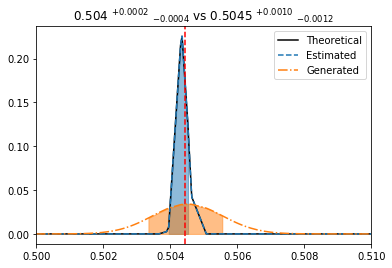

In [31]:
plt.plot(q_real, real_posterior, c='k', label='Theoretical')
plt.plot(q_posterior, posterior, linestyle='--', label='Estimated')
plt.fill_between(q_posterior[id1:id2+1], posterior[id1:id2+1],  alpha=0.5, color='C0')
plt.axvline(q_fid, linestyle='--', color='r')
max_est = q_posterior[np.argmax(posterior)]
upp_bound = q_posterior[id2] - max_est
low_bound = max_est - q_posterior[id1]

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_bins
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1_gen, id2_gen = np.argwhere(np.diff(condition)).flatten()
except:
    id1_gen, id2_gen = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.fill_between(likelihood_arr[id1_gen:id2_gen+1, 0], likelihood_arr[id1_gen:id2_gen+1, 1], alpha=0.5, color='C1')
max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2_gen] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1_gen]
plt.title(f'{max_est:.3} $ ^{{ + {upp_bound:.4f} }}$ $ _{{ - {low_bound:.4f} }}$ vs {max_est_gen:.4f} $ ^{{ + {upp_bound_gen:.4f} }}$ $ _{{ - {low_bound_gen:.4f} }}$')
plt.legend()
plt.xlim([0.50, 0.51])

In [22]:
q_fid

array([0.5421189])

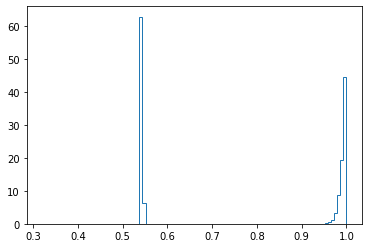

In [28]:
plt.hist(posterior_samples, 100, histtype='step', density='True');